In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from sklearn.metrics import confusion_matrix

In [2]:
train_df = pd.read_csv('GA2Datasets/UNSW_NB15_training-set.csv')
test_df = pd.read_csv('GA2Datasets/UNSW_NB15_testing-set.csv')

### Custom pipeline for data pre-processing

In [3]:
from imblearn.over_sampling import SMOTE
class PreProcessPipeline:
    def __init__(self, label_encode = True, process_label = 'Binary', smote = False):
        self.label_encode = label_encode
        self.process_label = process_label
        self.smote = smote
    
    def fit(self):
        return self

    def transform(self, df):
        df = df.drop('id', axis=1)
        df = df.copy()
        if self.label_encode:
            columns = ['proto', 'service', 'state', 'attack_cat']
            for column in columns:
                unique_values = df[column].unique()
                mapping = {value: index for index, value in enumerate(unique_values)}
                df[column] = df[column].map(mapping)

        if self.process_label == 'Binary':
            df.drop('attack_cat', axis=1, inplace=True)
        else:             
            df['attack_cat'], df['label'] = df['label'], df['attack_cat']
            df.drop('attack_cat', axis=1, inplace=True)   

        if self.smote:
            # Separate features and labels
            X = df.drop('label', axis=1)
            y = df['label']

            # Apply SMOTE for oversampling
            smote = SMOTE(sampling_strategy='auto', random_state=42)
            X_resampled, y_resampled = smote.fit_resample(X, y)

            # Convert NumPy arrays back to Pandas DataFrames
            X_resampled_df = pd.DataFrame(data=X_resampled, columns=X.columns)
            y_resampled_df = pd.DataFrame(data=y_resampled, columns=['label'])

            # Concatenate the features and label columns into a single DataFrame
            df = pd.concat([X_resampled_df, y_resampled_df], axis=1)   

        return df

In [4]:
train_df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [5]:
pipeline_train = PreProcessPipeline(label_encode=True, process_label='Binary')
pipeline_test = PreProcessPipeline(label_encode=True, process_label='Binary')
train_df = pipeline_train.transform(train_df)
test_df = pipeline_test.transform(test_df)

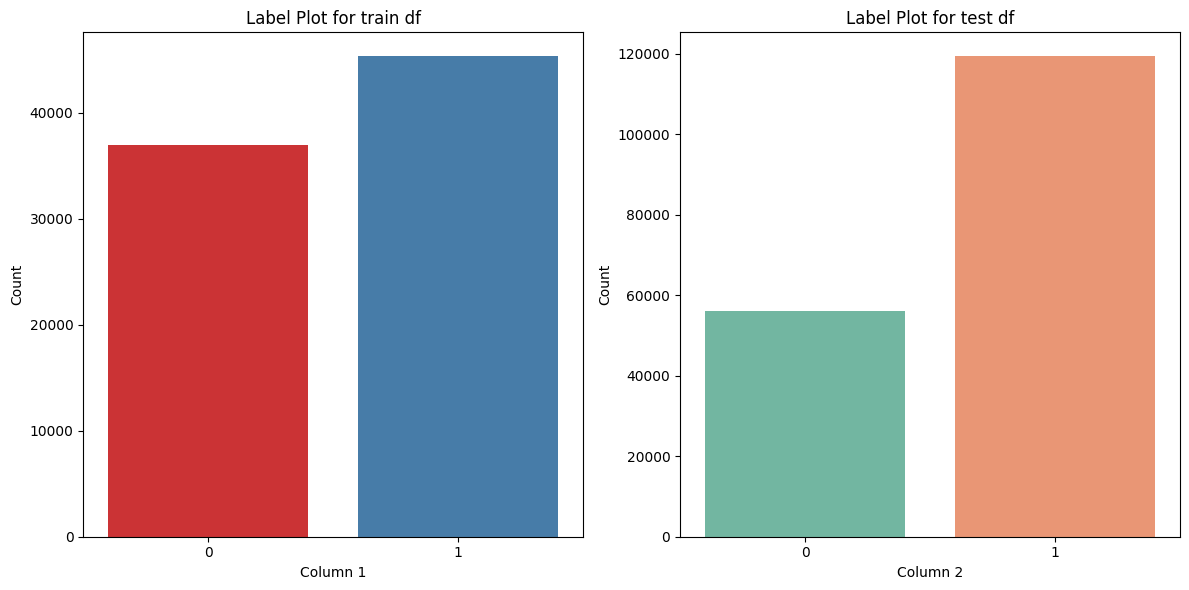

In [6]:
# Set up the figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot countplot for column1
sns.countplot(data=train_df, x='label', palette="Set1", ax=axes[0])
axes[0].set_title("Label Plot for train df")
axes[0].set_xlabel("Column 1")
axes[0].set_ylabel("Count")

# Plot countplot for column2
sns.countplot(data=test_df, x='label', palette="Set2", ax=axes[1])
axes[1].set_title("Label Plot for test df")
axes[1].set_xlabel("Column 2")
axes[1].set_ylabel("Count")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

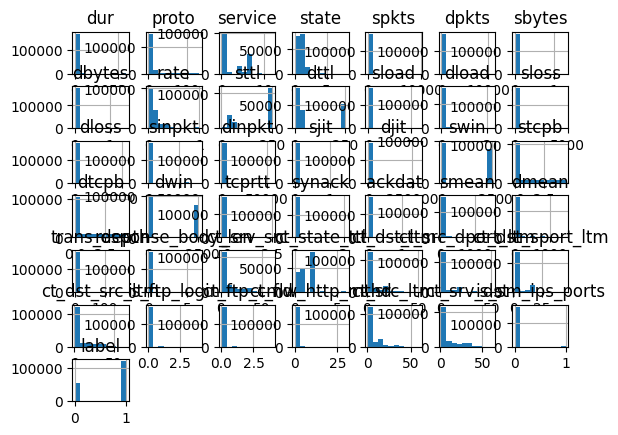

In [7]:
test_df.hist()
plt.grid()

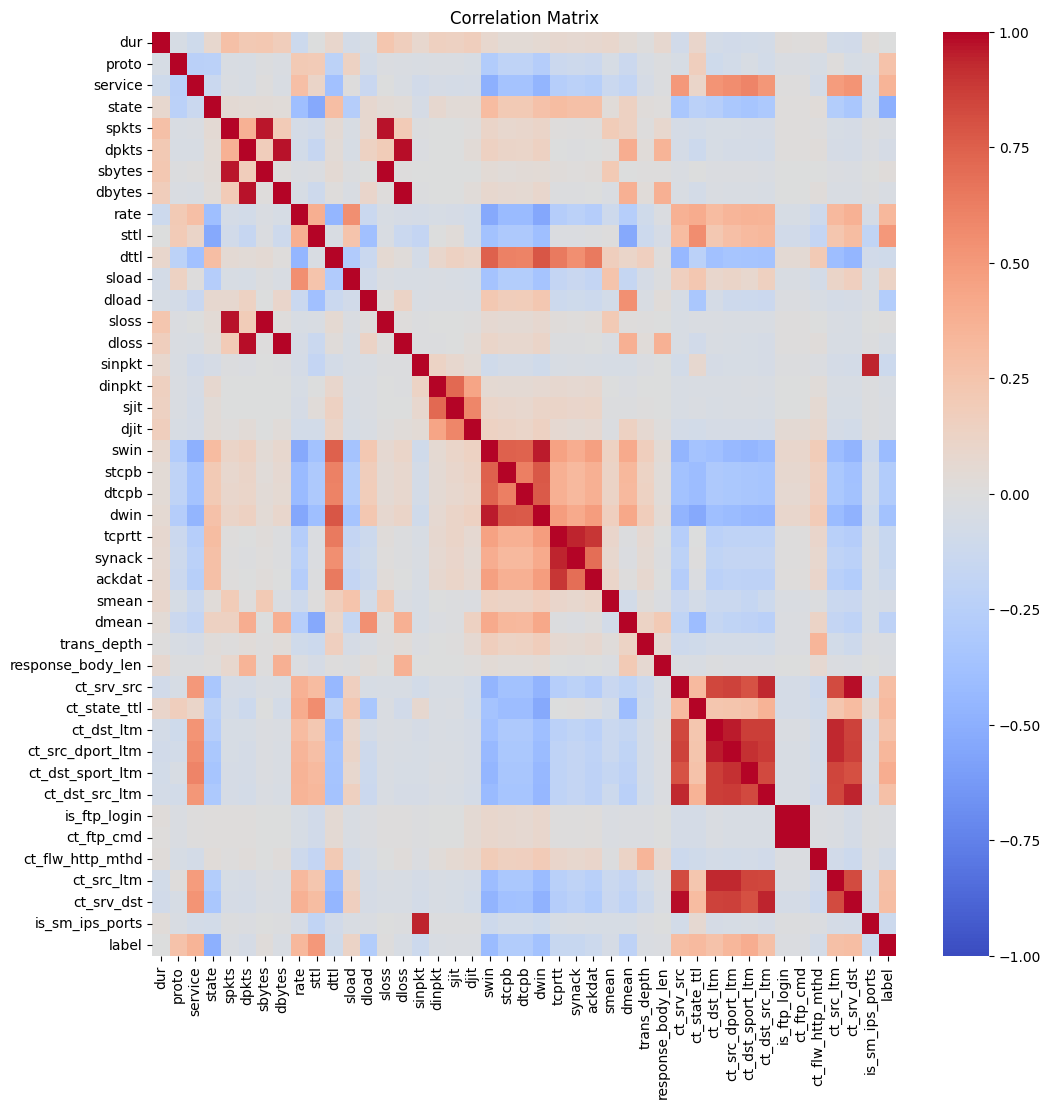

In [8]:
# Visualize - Correlation matrix

# Create a correlation matrix
corr_matrix = train_df.corr()

# Select the correlation values with 'label', label here means attack_cat
target_corr = corr_matrix['label']

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show() 

In [9]:
# Show the feature ranking in corr order 

# Calculate the absolute correlation values with the 'label'
target_corr_abs = corr_matrix['label'].abs()

# Sort the correlation values in descending order
sorted_corr = target_corr_abs.sort_values(ascending=False)

# Print the sorted correlation values and their corresponding attributes
for attribute, correlation in target_corr_abs.items():
    print(f"{attribute}: {correlation:.4f}")

dur: 0.0011
proto: 0.2592
service: 0.3568
state: 0.4993
spkts: 0.0277
dpkts: 0.0615
sbytes: 0.0206
dbytes: 0.0326
rate: 0.3286
sttl: 0.5042
dttl: 0.0986
sload: 0.1245
dload: 0.2805
sloss: 0.0064
dloss: 0.0444
sinpkt: 0.1208
dinpkt: 0.0376
sjit: 0.0274
djit: 0.0271
swin: 0.4145
stcpb: 0.2814
dtcpb: 0.2829
dwin: 0.3693
tcprtt: 0.1488
synack: 0.1499
ackdat: 0.1205
smean: 0.0611
dmean: 0.2115
trans_depth: 0.0258
response_body_len: 0.0164
ct_srv_src: 0.2902
ct_state_ttl: 0.3185
ct_dst_ltm: 0.2580
ct_src_dport_ltm: 0.3415
ct_dst_sport_ltm: 0.3937
ct_dst_src_ltm: 0.2800
is_ftp_login: 0.0162
ct_ftp_cmd: 0.0171
ct_flw_http_mthd: 0.0750
ct_src_ltm: 0.2765
ct_srv_dst: 0.2929
is_sm_ips_ports: 0.1174
label: 1.0000


In [10]:
'''
Author: Khanh Nguyen
Name: PySpark Dataframe Pipeline
Description:
    This class is used to create a pipeline for PySpark dataframe, accept 2 boolean parameter: smote & standardize.
    Features 
        (Default)
        - Resample: Resample the dataframe
        - Vectorize: Vectorize the dataframe
        (activate by setting the parameter to True):
        - SMOTE: Oversampling the minority class
        - Standardize: Standardize the dataframe using z-score
'''

from pyspark.sql.functions import col
class SparkDFPipeline:
    def __init__(self, standardize=False):
        self.standardize = standardize
    
    def fit(self):
        return self
    
    def transform(self, train_df, test_df):      
        if self.standardize:
            # Standardize the df

            # Resample the df
            num_partitions = 500
            repartitioned_df = train_df.repartition(num_partitions)

            exclude = ['proto', 'service', 'state']
            input_columns = train_df.columns[:-1]
            selected_columns = [col for col in input_columns if col not in exclude]
            # Vectorize the df
            assembler = VectorAssembler(inputCols=selected_columns, outputCol='features')
            train_df = assembler.transform(repartitioned_df)
            test_df = assembler.transform(test_df)

            # Standardize the df
            scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
            scaler_model = scaler.fit(train_df)
            train_df = scaler_model.transform(train_df)

            scaler_model = scaler.fit(test_df)
            test_df = scaler_model.transform(test_df)
            test_df = test_df.drop('features')
            train_df = train_df.drop('features')
            
            # put back the categorical columns
            input_cols = ['scaled_features', 'proto', 'service', 'state']
            output_col = "features"
            assembler1 = VectorAssembler(inputCols=input_cols, outputCol=output_col)
            train_df = assembler1.transform(train_df)
            test_df = assembler1.transform(test_df)

            # return result
            test_df = test_df.select('features', 'label')
            train_df = train_df.select('features', 'label')
        else:
            # Normal vectorize df
            num_partitions = 500
            repartitioned_df = train_df.repartition(num_partitions)
            input_columns = train_df.columns[:-1]
            assembler = VectorAssembler(inputCols=input_columns, outputCol='features')
            train_df = assembler.transform(repartitioned_df)
            train_df = train_df.select('features', 'label')
            test_df = assembler.transform(test_df)
              
        return train_df, test_df

In [11]:
def evaluate_model(model, val_data, model_name):
    # Make predictions on the validation data
    predictions = model.transform(val_data)

    # Evaluate the model using a BinaryClassificationEvaluator for AUC
    auc_evaluator = BinaryClassificationEvaluator(labelCol='label')
    auc = auc_evaluator.evaluate(predictions)

    # Evaluate the model using a BinaryClassificationEvaluator for areaUnderPR
    pr_evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderPR')
    area_under_pr = pr_evaluator.evaluate(predictions)

    # Calculate additional metrics
    sensitivity = predictions.filter("label = 1 and prediction = 1").count() / predictions.filter("label = 1").count()
    specificity = predictions.filter("label = 0 and prediction = 0").count() / predictions.filter("label = 0").count()
    precision = predictions.filter("prediction = 1").count() / predictions.filter("prediction = 1 or prediction = 0").count()
    recall = sensitivity
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = (predictions.filter("label = prediction").count()) / predictions.count()
    # youdens_j = sensitivity + specificity - 1
    # balanced_accuracy = (sensitivity + specificity) / 2

    # Convert Spark DataFrames to Pandas DataFrames for visualization
    y_true_pd = predictions.select('label').toPandas()
    y_pred_pd = predictions.select('prediction', 'probability').toPandas()
    
    # Convert prediction probabilities to binary predictions
    y_pred_binary = [1 if prob[1] >= 0.5 else 0 for prob in y_pred_pd['probability']]

    # Generate the confusion matrix
    cm = confusion_matrix(y_true_pd['label'], y_pred_binary)

    # Display the confusion matrix as a heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-default', 'Default'], 
                yticklabels=['Non-default', 'Default'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(model_name)
    plt.show()


    # Create a dictionary of model evaluation metrics
    eval_metrics = {
        'AUC': auc,
        'AreaUnderPR': area_under_pr,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score,
        'Accuracy': accuracy,
        # "Youden's J Index": youdens_j,
        # 'Balanced Accuracy': balanced_accuracy
    }

    return eval_metrics

In [12]:
spark = SparkSession.builder.appName("CSCI316GP2").getOrCreate()

sparktrain_df = spark.createDataFrame(train_df)
sparktest_df = spark.createDataFrame(test_df)

In [13]:
# Pipeline example
pipeline = SparkDFPipeline(standardize=False)
train, test = pipeline.transform(sparktrain_df, sparktest_df)

pipeline = SparkDFPipeline(standardize=True)
FT_train, FT_test = pipeline.transform(sparktrain_df, sparktest_df)


# Default RF model

In [14]:
# Train a RandomForest model
default_rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42)

# Create a pipeline
default_pipeline = Pipeline(stages=[default_rf])

# Train the pipeline
default_model = default_pipeline.fit(train)

# Make predictions on the test data
default_predictions = default_model.transform(test)

# Create an evaluator for accuracy
default_accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
default_accuracy = default_accuracy_evaluator.evaluate(default_predictions)
print("Accuracy = %g" % default_accuracy)

# Create an evaluator for f1 score
default_f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")
default_f1_score = default_f1_evaluator.evaluate(default_predictions)
print("F1 Score = %g" % default_f1_score)

# Create an evaluator for precision
default_precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
default_precision = default_precision_evaluator.evaluate(default_predictions)
print("Precision = %g" % default_precision)

Accuracy = 0.904255
F1 Score = 0.906457
Precision = 0.918649


# Fine-tuned RF Model

In [15]:
# Train a RandomForest model
tuned_rf = RandomForestClassifier(labelCol="label", featuresCol="features", seed=42)
tuned_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')


# Define the parameter grid
param_grid = ParamGridBuilder() \
            .addGrid(tuned_rf.numTrees, [10,20,30]) \
            .addGrid(tuned_rf.maxDepth, [5,6,8]) \
            .addGrid(tuned_rf.impurity, ['gini']) \
            .build()

# Create a CrossValidator instance
crossval = CrossValidator(estimator=tuned_rf,
                          estimatorParamMaps=param_grid,
                          evaluator=tuned_evaluator,
                          numFolds=3)  # Number of cross-validation folds

# Run cross-validation, and choose the best set of parameters
cv_model = crossval.fit(FT_train)
best_model = cv_model.bestModel

# Get the best parameters
best_numTrees = best_model.getOrDefault('numTrees')
best_maxDepth = best_model.getOrDefault('maxDepth')
best_impurity = best_model.getOrDefault('impurity')

# Print the best parameters
print("Best numTrees:", best_numTrees)
print("Best maxDepth:", best_maxDepth)
print("Best impurity:", best_impurity)

# Make predictions on the test data
best_predictions = best_model.transform(FT_test)

# Create an evaluator for accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
best_accuracy = accuracy_evaluator.evaluate(best_predictions)
print("Accuracy = %g" % best_accuracy)

# Create an evaluator for f1 score
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="f1")
best_f1_score = f1_evaluator.evaluate(best_predictions)
print("F1 Score = %g" % best_f1_score)

# Create an evaluator for precision
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
best_precision = precision_evaluator.evaluate(best_predictions)
print("Precision = %g" % best_precision)

Best numTrees: 20
Best maxDepth: 8
Best impurity: gini
Accuracy = 0.891394
F1 Score = 0.893489
Precision = 0.901758


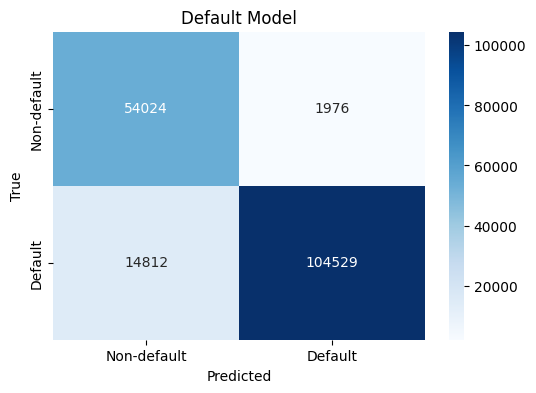

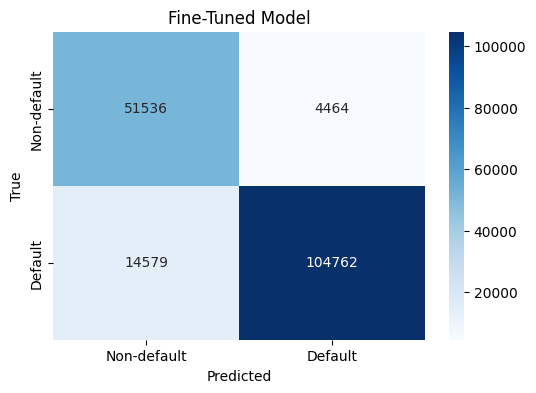

Evaluation Results:
Metric              Default Model       Fine-Tuned Model    
AUC                 0.9839492828623141  0.9769315437036967  
AreaUnderPR         0.9922966005412066  0.9875935494085106  
Sensitivity         0.8758850688363596  0.8778374573700573  
Specificity         0.9647142857142857  0.9202857142857143  
Precision           0.6074164057465168  0.6229347385950804  
Recall              0.8758850688363596  0.8778374573700573  
F1-Score            0.717355129049858   0.7287387766190858  
Accuracy            0.9042551371327869  0.8913944827507543  


In [16]:
# Evaluate models using the evaluate_model function
evaluation_results_default = evaluate_model(default_model, test, 'Default Model')  # Use the 'test' dataset

# Evaluate models using the evaluate_model function
evaluation_results_tuned = evaluate_model(best_model, FT_test, 'Fine-Tuned Model')  # Use the 'test' dataset

# Print evaluation results for both models side by side

print("Evaluation Results:")
print(f"{'Metric':<20}{'Default Model':<20}{'Fine-Tuned Model':<20}")
print("=" * 60)

for metric in evaluation_results_default.keys():
    default_value = evaluation_results_default[metric]
    tuned_value = evaluation_results_tuned[metric]
    print(f"{metric:<20}{default_value:<20}{tuned_value:<20}")

In [17]:
#spark.stop()